# Gaussian Mixture Model Inversion Using Optimal Transport

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Core_Functions import gmm_base as gb
from Core_Functions import gmm_plot as gp
from Core_Functions import optimisation as op
from scipy.linalg import eigh
from scipy.stats import multivariate_normal

## Optimal Transport

The goal of optimal transport (OT) is to rearrange on probability distribution into another whilst minimising the requisite work. This applies to both continuous and discrete distributions although the methods for each differ. For reasons that will become clear in later sections, OT will be formulated in a discrete setting and with discrete notation. The source is the distribution prior to transport (denoted $\mathbf{f}$) and the target is the distribution after transport (denoted $\mathbf{g}$). To be probability distributions, they both must belong to the probability simplex. That is, $\mathbf{f}\in\Delta^n,\mathbf{g}\in\Delta^m$ where

\begin{equation}
\Delta^n = \left\{ \mathbf{p}\in\mathbb{R}_+^n : \sum_{i=1}^n p_i = 1 \right\}
\end{equation}

A transport plan $\mathbf{P}\in\mathbb{R}_+^{n\times m}$ assigns the amount of mass that must be moved between each combination of points in the source and target distributions. For this to validly transport the mass from the source to the target, the row and column sums must be the source and target distributions. These can be collected into the set $\Pi$.

\begin{equation}
\Pi(\mathbf{f},\mathbf{g}) = \left\{\mathbf{P}\in\mathbb{R}_+^{n\times m} : \mathbf{P}\mathbb{1}_m = \mathbf{f}, \mathbf{P}^T\mathbb{1}_n = \mathbf{g} \right\}
\end{equation}

Now, the required work for transport can be defined as the amount of mass moved between each set of points multiplied by the transport cost between these points. The transport costs can be collected into the cost matrix $\mathbf{C}$ where $C_{i,j}$ is the cost of transport from $f_i$ to $g_j$. This therefore contains information on the geometry of the space. OT is therefore the task of choosing a transport plan that satisfies the following expression.

\begin{equation}
\min_{\mathbf{P}\in\Pi(\mathbf{f},\mathbf{g})} \sum_{i=1}^n \sum_{j=1}^m C_{i,j} P_{i,j} = \min_{\mathbf{P}\in\Pi(\mathbf{f},\mathbf{g})} \langle \mathbf{C},\mathbf{P} \rangle
\end{equation}


A common choice for the cost when the source and target are supported on $\mathbb{R}^d$ is $\| x_i - y_j\|^p$ where $x_i$ and $y_j$ are the locations of $f_i$ and $g_j$ respectively. This leads to the definition of the $p$-Wasserstein distance, which is the minimal amount of work for transport under this cost matrix.

\begin{align}
\mathcal{W}_p^p(\mathbf{f},\mathbf{g}) &= \min_{\mathbf{P}\in\Pi(\mathbf{f},\mathbf{g})} \sum_{i=1}^n \sum_{j=1}^m \|x_i - y_j \| ^p P_{i,j} \\
&= \min_{\mathbf{P}\in\Pi(\mathbf{f},\mathbf{g})} \langle \mathbf{C},\mathbf{P} \rangle
\end{align}

## Gaussian Mixture Model Theory

A Gaussian mixture model (GMM) is used to express a collection of data as the sum of weighted Gaussian distributions, this idea extending to any number of dimensions. If the GMM is denoted $f$ where each of the Gaussian components are $f_i$ with mean vector $\mu_i$ and covariance matrix $\Sigma_i$, then it has the following form.

\begin{equation}
f(x) = \sum_{i=1}^n p_i f_i(x)
\end{equation}

where the weights $p_i$ are from the vector $\mathbf{p}\in \Delta^n$. 

GMMs are of interest in the context of optimal transport as there exists a simple, closed form analytical solution for the 2-Wasserstein distance between any two Gaussian distributions. If $f$ is of Gaussian distribution with mean $\mu\in\mathbb{R}^d$ and covariance $A\in\mathbb{R}^{d\times d}$ and $g$ is also of Gaussian distribution with mean $\nu\in\mathbb{R}^{d}$ and covariance $B\in\mathbb{R}^{d\times d}$, the 2-Wasserstein distance between them is shown below. 

\begin{equation}
\mathcal{W}_2^2(f,g) = \| \mu - \nu\|^2 + \text{tr}(A + B - 2(A^{\frac{1}{2}} B A^{\frac{1}{2}})^{\frac{1}{2}})
\end{equation}

## Gaussian-Wasserstein Distance

For inversion using the optimal transport, the goal is to minimise the Wasserstein distance between the source (synthetic data) and target (observed data) by varying the model parameters. Most computational methods (excluding Monge-Ampere solvers) consider data as discrete points to perform transport between. This means that for $n$ points in each the source and target distributions, the transport matrix consists of $n^2$ point combinations for which the linear program must be solved. As $n$ grows, the computation time balloons, especially for higher dimensional data evaluated on a uniform grid. 

From the linear program, it can be seen that the transport plan defines the amount of mass to be moved between the discrete points and the cost function defines elementary transport cost between the Dirac delta functions. This motivates the replacement of the Euclidian cost function with the analytical solution for the Wasserstein distance between Gaussian distributions. This new metric then defines transport between distributions that are a weighted sum of Gaussian distributions (GMMs) rather than the weighted sum of point masses (all discrete distributions). As was the case for ordinary discrete OT, the transport plan is between the weights on the elementary basis functions. 

The source and target distributions can be respectively defined as below.

\begin{align}
f(x) &= \sum_{i=1}^n p_i f_i(x) \\
g(y) &= \sum_{j=1}^m q_j g_j(y)
\end{align}

As by the definition of a GMM, $\mathbf{p}\in\Delta^n$, $\mathbf{q}\in\Delta^m$. The components are of Gaussian distribution with means $\mu_i$ and covariances $A_i$ for the source and means $\nu_j$ and covariances $B_j$ for the target. This then leads to the definition of the Gaussian-Wasserstein distance, denoted $\mathcal{GW_2^2}$.

\begin{align}
\mathcal{GW}_2^2(f,g) &= \min_{\mathbf{P}\in\Pi (\mathbf{p},\mathbf{q})} \sum_{i=1}^n\sum_{j=1}^m P_{i,j} \mathcal{W}_2^2(f_i,g_j) \\
&= \min_{\mathbf{P}\in\Pi (\mathbf{p},\mathbf{q})} \langle \mathbf{P},\mathbf{W} \rangle
\end{align}

This defines a metric on the space of all GMMs. All intermediate distributions when performing the transport (points along the geodesic) are also forced to be GMMs, which is not the case for normal OT, and the resulting suboptimality of this means that $\mathcal{GW}_2^2(f,g) \geq \mathcal{W}_2^2(f,g)$. The two metrics should therefore not be compared but we hope that the Gaussian-Wasserstein distance displays similar attractive properties to the ordinary Wasserstein distance.

## Entropic Regularisation

The above linear program can be modified so that transport plans of high entropy are promoted. This has two key advantages: it generates an efficient matrix scaling algorithm for solving the approximate OT problem, and it gives continuous derivatives. The first of these factors is not of great importance here as the mixtures to be considered will have few components so the ordinary linear program is sufficient. However, the continuous derivatives may be important for optimisation procedures. If the entropy of the plan is denoted $H(\mathbf{P})$, then the entropically regularised problem is as follows.

\begin{equation}
\mathcal{GW}_{2,\gamma}^2(f,g) = \min_{\mathbf{P}\in\Pi (\mathbf{p},\mathbf{q})} \langle \mathbf{P},\mathbf{W} \rangle - H(\mathbf{P})
\end{equation}

The Lagrangian of this with dual variables $\mathbf{a}\in\mathbb{R}^n$ and $\mathbf{b}\in\mathbb{R}^m$ can be taken with the partial derivative with respect to the transport plan components set to zero.

\begin{align}
\mathcal{L}(\mathbf{P},\mathbf{a},\mathbf{b}) &= \langle \mathbf{P},\mathbf{W}\rangle - \gamma H(\mathbf{P}) - \langle \mathbf{a}, \mathbf{P}\mathbb{1}_m - \mathbf{p}\rangle - \langle \mathbf{b}, \mathbf{P}^T\mathbb{1}_n\mathbf{q} \rangle \\
\frac{\partial \mathcal{L}(\mathbf{P},\mathbf{a},\mathbf{b})}{\partial P_{i,j}} &= W_{i,j} + \gamma\log(P_{i,j}) - a_i - b_j = 0 \\
\therefore\: \mathbf{P} &= \text{diag}(\mathbf{u})\mathbf{K}\text{diag}(\mathbf{v})
\end{align} 

The variables in this final expression are linked to those earlier via $u_i = \exp(a_i/\gamma)$, $v_j = \exp(b_j/\gamma)$, and $K_{i,j} = \exp(-W_{i,j}/\gamma)$. The iterative 'Sinkhorn's Algorithm' can be used to find the left and right scaling vectors.

\begin{align}
\mathbf{u}^{(k+1)} &= \frac{\mathbf{p}}{\mathbf{Kv}^{(k)}} \\
\mathbf{v}^{(k+1)} &= \frac{\mathbf{q}}{\mathbf{K^T u}^{(k+1)}}
\end{align}

Once this has been iterated to sufficient accuracy, the optimal dual vectors can be found.

\begin{align}
\mathbf{a} &= \gamma\log(\mathbf{u}) \\
\mathbf{b} &= \gamma\log(\mathbf{v})
\end{align}

This then gives the required approximation to the Gaussian-Wasserstein distance.

\begin{equation}
\mathcal{GW}_{2,\gamma}^2 = \langle \mathbf{a}, \mathbf{p} \rangle + \langle \mathbf{b}, \mathbf{q} \rangle
\end{equation}

From their relation to $\mathbf{P}$, the first dual vector can be shifted to sum to zero.

\begin{equation}
\mathbf{a}^\ast = \mathbf{a} - \text{mean}(\mathbf{a}), \:\: \mathbf{b}^\ast = \mathbf{b} + \text{mean}(\mathbf{a})
\end{equation}

From the dual problem and that this sums to zero, the gradient of the Gaussian-Wasserstein distance with respect to the source weights has a simple form.

\begin{equation}
\nabla_\mathbf{p} \mathcal{GW}_{2,\gamma}^2 = \mathbf{a}^\ast
\end{equation}

Furthermore, from the smoothed primal problem, the gradient with respect to the cost matrix also has a simple form.

\begin{equation}
\nabla_\mathbf{W} \mathcal{GW}_{2,\gamma}^2 = \mathbf{P}
\end{equation}

Now, the gradient of interest is with respect to the mean vectors and covariance matrices so the chain rule can then be used to find these. It can be seen simply from the analytical 2-Wasserstein distance between Gaussian distributions that

\begin{equation}
\frac{\partial \mathcal{W}_2^2(f_i,g_j)}{\partial \mu_i} = \frac{\partial W_{i,j}}{\partial \mu_i} = 2\| \mu_i - \nu_j\|
\end{equation}

The derivation for the derivative with respect to the covariance matrix is more involved but has the following result.

\begin{equation}
\frac{\partial \mathcal{W}_2^2(f_i,g_j)}{\partial A_i} = \frac{\partial W_{i,j}}{\partial A_i} = \mathbb{I}_d - A_i^{-\frac{1}{2}}(A_i^{\frac{1}{2}}B_jA_i^{\frac{1}{2}})^{\frac{1}{2}}A_i^{-\frac{1}{2}}
\end{equation}

Via the chain rule, we then have the following results that are used to find the derivatives in the following examples.

\begin{align}
\frac{\partial \mathcal{GW}_{2,\gamma}^2}{\partial \mu_i} &= \sum_{j=1}^m P_{i,j}\frac{\partial W_{i,j}}{\partial \mu_i} \\
\frac{\partial \mathcal{GW}_{2,\gamma}^2}{\partial A_i} &= \sum_{j=1}^m P_{i,j}\frac{\partial W_{i,j}}{\partial A_i}
\end{align}

## Examples

To study the behaviour of this metric, some examples GMMs will be considered. The simplest possible case will initially be studied - the distance between two one-dimensional, one component mixtures.

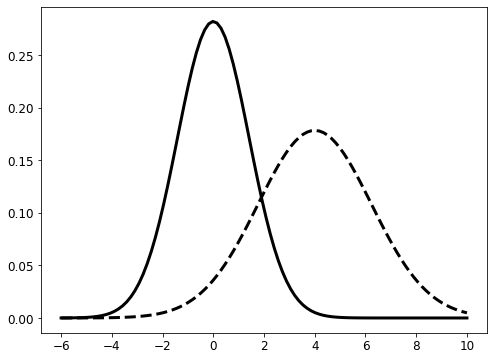

In [2]:
#firstly, need to define a source and target distribution

#each of these have only 1 dimension and 1 component
source = gb.Gaussian_Mixture(1,1)
target = gb.Gaussian_Mixture(1,1)

#initialise their weights, means, and covariances
sw = np.array([1])
sm = np.zeros([1,1])
sc = np.zeros([1,1,1])

tw = np.array([1])
tm = np.zeros([1,1])
tc = np.zeros([1,1,1])

#assign some example values
sm[0,0] = 0
sc[0,0,0] = 2
tm[0,0] = 4
tc[0,0,0] = 5

source.assign_w(sw)
source.assign_m(sm)
source.assign_cov(sc)

target.assign_w(tw)
target.assign_m(tm)
target.assign_cov(tc)

#visualise the result
fig, ax = gp.Source_Target_1D(source,target,[-6,10])

Now some misfit surfaces and their gradients will be considered for this problem. Keeping the target above constant, the two source parameters (mean and variance) will be altered simulaneously to give a 2D misfit surface.

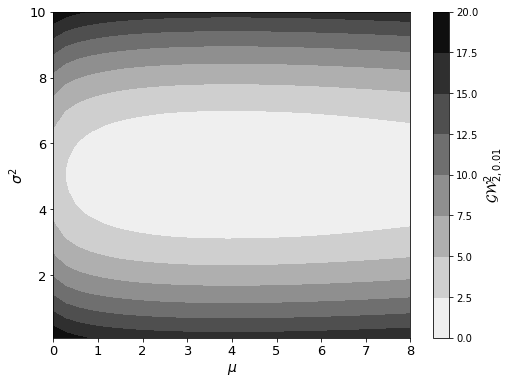

In [3]:
cov_test = np.linspace(0.1,10,30) #test values for the source variance
m_test = np.linspace(0,8,30) # test values for source mean

GW = np.zeros([30,30])

for i in range(30):
    sm[0,0] = m_test[i]
    source.assign_m(sm)
    
    for j in range(30):
        sc[0,0,0] = cov_test[j]
        source.assign_cov(sc)
        GW[i,j] = gb.GMM_Transport(source,target,0.01)[0]
        
M, C = np.meshgrid(m_test,cov_test)

fig, ax = plt.subplots(figsize=[8,6])

contour = ax.contourf(M,C,GW,cmap='binary')
cb = plt.colorbar(contour,ax=ax)
cb.set_label(label=r'$\mathcal{GW}_{2,0.01}^2$',fontsize=14)
ax.set_xlabel(r'$\mu$',fontsize=14)
ax.set_ylabel(r'$\sigma^2$',fontsize=14)
ax.tick_params(labelsize='13')

As expected for this simple case, there is a single basin about the point where the source and target are identical. It therefore initially appears to be a good candidate for a misfit function although more complex examples are required to varify this. Now a two component examples will be considered.

In [4]:
source = gb.Gaussian_Mixture(2,1)
target = gb.Gaussian_Mixture(2,1)

#initialise their weights, means, and covariances
sw = np.array([0.5,0.5])
sm = np.zeros([2,1])
sc = np.zeros([2,1,1])

tw = np.array([0.5,0.5])
tm = np.zeros([2,1])
tc = np.zeros([2,1,1])

#assign some example values
sm[0,0] = -2
sm[1,0] = 3
sc[0,0,0] = 2
sc[1,0,0] = 5

tm[0,0] = -2
tm[1,0] = 3
tc[0,0,0] = 2
tc[1,0,0] = 5


source.assign_w(sw)
source.assign_m(sm)
source.assign_cov(sc)

target.assign_w(tw)
target.assign_m(tm)
target.assign_cov(tc)

GW1 = np.zeros([30,30])
GW2 = np.zeros([30,30])
GW3 = np.zeros([30])

dGW1 = np.zeros([30,30,2])
dGW2 = np.zeros([30,30,2])
dGW3 = np.zeros([30])


cov_test = np.linspace(0.1,10,30) #test values for the source variance
m_test = np.linspace(-12,12,30) # test values for source mean
w_test = np.linspace(0.01,0.99,30) #test values for component weights

#firstly, do the mean experiment
for i in range(30):
    sm[0,0] = m_test[i]
    for j in range(30):
        sm[1,0] = m_test[j]
        source.assign_m(sm)
        GW1[i,j], P, alpha = gb.GMM_Transport(source,target,0.01)
        grad = gb.Wasserstein_Gradients(source,target,P,alpha)
        dGW1[i,j,:] = grad.m.reshape([2])

#reset the source mean for the next test 
sm[0,0] = -2
sm[1,0] = 3

#now do the variance experiment
for i in range(30):
    sc[0,0,0] = cov_test[i]
    for j in range(30):
        sc[1,0,0] = cov_test[j]
        source.assign_cov(sc)
        GW2[i,j], P, alpha = gb.GMM_Transport(source,target,0.01)
        grad = gb.Wasserstein_Gradients(source,target,P,alpha)
        dGW2[i,j,:] = grad.cov.reshape([2])
        
#reset the variance
sc[0,0,0] = 2
sc[1,0,0] = 5

#now alter the weights
for i in range(30):
    source.assign_w(np.array([w_test[i],1-w_test[i]]))
    GW3[i], P, alpha = gb.GMM_Transport(source,target,0.01)
    grad = gb.Wasserstein_Gradients(source,target,P,alpha)
    dGW3[i] = grad.w[0]

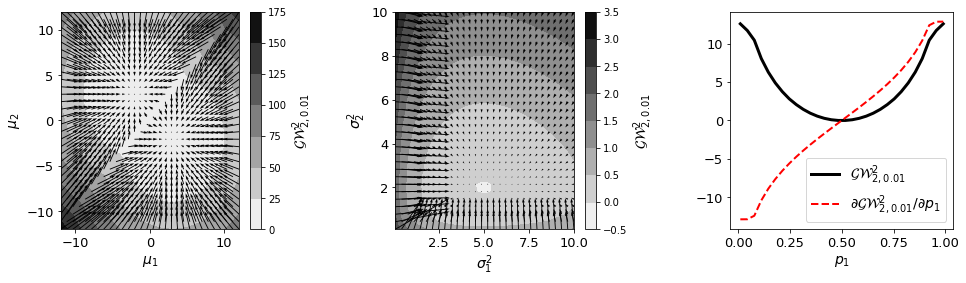

In [5]:
#can now plot the results
M1, M2 = np.meshgrid(m_test,m_test)
C1, C2 = np.meshgrid(cov_test,cov_test) 

fig, ax = plt.subplots(ncols=3,figsize=[16,4])
plt.subplots_adjust(wspace=0.5)

contour = ax[0].contourf(M1,M2,GW1,cmap='binary')
cb = plt.colorbar(contour,ax=ax[0])
cb.set_label(label=r'$\mathcal{GW}_{2,0.01}^2$',fontsize=14)
ax[0].set_xlabel(r'$\mu_1$',fontsize=14)
ax[0].set_ylabel(r'$\mu_2$',fontsize=14)
ax[0].tick_params(labelsize='13')

ax[0].quiver(M1,M2,-dGW1[:,:,1],-dGW1[:,:,0],scale=100,width=0.005)

contour = ax[1].contourf(C1,C2,GW2,cmap='binary')
cb = plt.colorbar(contour,ax=ax[1])
cb.set_label(label=r'$\mathcal{GW}_{2,0.01}^2$',fontsize=14)
ax[1].set_xlabel(r'$\sigma_1^2$',fontsize=14)
ax[1].set_ylabel(r'$\sigma_2^2$',fontsize=14)
ax[1].tick_params(labelsize='13')

ax[1].quiver(C1,C2,-dGW2[:,:,1],-dGW2[:,:,0],scale=10,width=0.005)

ax[2].plot(w_test,GW3,'-k',linewidth=3,label = r'$\mathcal{GW}_{2,0.01}^2$')
ax[2].set_xlabel(r'$p_1$',fontsize=14)
ax[2].tick_params(labelsize='13')

ax[2].plot(w_test,dGW3,'--r',linewidth=2,label = r'$\partial\mathcal{GW}_{2,0.01}^2/\partial p_1$')
ax[2].legend(fontsize=14)

plt.show()

[DISCUSS DUAL BASIN IN MEANS - SHOULD NOT BE A PROBLEM AS NOT UNIQUE WHEN COMPONENTS ARE SWAPPED]

In [7]:
#now consider the same experiment but for the L2 misfit surfaces

#reset the parameters
sm[0,0] = -2
sm[1,0] = 3
sc[0,0,0] = 2
sc[1,0,0] = 5

tm[0,0] = -2
tm[1,0] = 3
tc[0,0,0] = 2
tc[1,0,0] = 5


source.assign_w(sw)
source.assign_m(sm)
source.assign_cov(sc)

target.assign_w(tw)
target.assign_m(tm)
target.assign_cov(tc)

L2_1 = np.zeros([30,30])
L2_2 = np.zeros([30,30])
L2_3 = np.zeros([30])


domain = np.linspace(-20,20,200)
g_d = np.zeros(200)



for j in range(target.n):
    g_d += target.w[j] * multivariate_normal.pdf(domain, mean = target.m[j,:], cov = target.cov[j,:,:])

cov_test = np.linspace(0.1,10,30) #test values for the source variance
m_test = np.linspace(-12,12,30) # test values for source mean
w_test = np.linspace(0.01,0.99,30) #test values for component weights

#firstly, do the mean experiment
for i in range(30):
    sm[0,0] = m_test[i]
    for j in range(30):
        sm[1,0] = m_test[j]
        source.assign_m(sm)
        f_d = np.zeros(200)
        for k in range(source.n):
            f_d += source.w[k] * multivariate_normal.pdf(domain, mean = source.m[k,:], cov = source.cov[k,:,:])
        L2_1[i,j] = np.linalg.norm(f_d - g_d)**2

#reset the source mean for the next test 
sm[0,0] = -2
sm[1,0] = 3

#now do the variance experiment
for i in range(30):
    sc[0,0,0] = cov_test[i]
    for j in range(30):
        sc[1,0,0] = cov_test[j]
        source.assign_cov(sc)
        f_d = np.zeros(200)
        for k in range(source.n):
            f_d += source.w[k] * multivariate_normal.pdf(domain, mean = source.m[k,:], cov = source.cov[k,:,:])
        L2_2[i,j] = np.linalg.norm(f_d - g_d)**2
      
        
#reset the variance
sc[0,0,0] = 2
sc[1,0,0] = 5

#now alter the weights
for i in range(30):
    source.assign_w(np.array([w_test[i],1-w_test[i]]))
    f_d = np.zeros(200)
    for k in range(source.n):
        f_d += source.w[k] * multivariate_normal.pdf(domain, mean = source.m[k,:], cov = source.cov[k,:,:])
    L2_3[i] = np.linalg.norm(f_d - g_d)**2
    

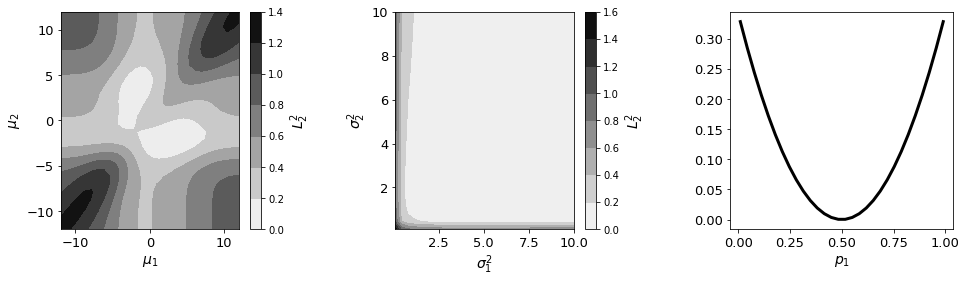

In [8]:
#can now plot the results
M1, M2 = np.meshgrid(m_test,m_test)
C1, C2 = np.meshgrid(cov_test,cov_test) 

fig, ax = plt.subplots(ncols=3,figsize=[16,4])
plt.subplots_adjust(wspace=0.5)

contour = ax[0].contourf(M1,M2,L2_1,cmap='binary')
cb = plt.colorbar(contour,ax=ax[0])
cb.set_label(label=r'$L_2^2$',fontsize=14)
ax[0].set_xlabel(r'$\mu_1$',fontsize=14)
ax[0].set_ylabel(r'$\mu_2$',fontsize=14)
ax[0].tick_params(labelsize='13')


contour = ax[1].contourf(C1,C2,L2_2,cmap='binary')
cb = plt.colorbar(contour,ax=ax[1])
cb.set_label(label=r'$L_2^2$',fontsize=14)
ax[1].set_xlabel(r'$\sigma_1^2$',fontsize=14)
ax[1].set_ylabel(r'$\sigma_2^2$',fontsize=14)
ax[1].tick_params(labelsize='13')


ax[2].plot(w_test,L2_3,'-k',linewidth=3,label = r'$L_2^2$')
ax[2].set_xlabel(r'$p_1$',fontsize=14)
ax[2].tick_params(labelsize='13')


plt.show()

## BFGS Algorithm

The problem is now to minimise the above defined $\mathcal{GW}_{2,\gamma}^2$. The quasi-Newton BFGS scheme will be implemented 
to do this. As a line search method, it is of the following form.

\begin{equation}
x_{k+1} = x_{k} + \alpha_k p_k
\end{equation}

Here, $\alpha_k\in\mathbb{R}_+$ is the step size and $p_k\in\mathbb{R}^n$ is the search direction where $n$ is the number of unknown parameters. Both of this must be computed for the update to then be applied. 

### Computing the Search Direction

Firstly, the search direction will be considered. For BFGS, this is defined as below.

\begin{equation}
p_k = -H_k\nabla f(x_k)
\end{equation}

Here, $H_k$ is an approximation of the inverse Hessian matrix. Importantly, it is approximated without the use of second derivatives, using instead a finite difference method with the previous iteration. If $y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$ and $s_k = x_{k+1} - x_k$, then the following update to the Hessian approximation can be made.

\begin{equation}
H_{k+1} = \left(I - \frac{s_ky_k^T}{y_k^T s_k}\right)H_k\left(I - \frac{y_k s_k^T}{y_k^T s_k}\right) + \frac{s_k s_k^T}{y_k^T s_k}
\end{equation}

An inital value for $H_0$ is of course needed but can be chosen to be the identity which gives the steepest descent method for the first iteration.

A simplification of the earlier OT notation will now be made for this algorithm. The target distribution will be fixed, so be ommitted as an argument for the Wasserstein distance function. If the source mixture parameters are collected into the vector $x$ and the Gaussian-Wasserstein distance at the $k$-th iteration is $\mathcal{GW}(x_k) = \mathcal{GW}_k$, then the scheme can be written as below.

\begin{equation}
x_{k+1} = x_k - \alpha_k H_k\nabla \mathcal{GW}_k
\end{equation}

In [ ]:
#so we now want a way to update the Hessian if we know the change in parameters and 
#gradient with the previous iteration.

def Update_H(H,s,y):
    """
    Updates the approximation of the inverse Hessian for the quasi-Newton BFGS method.
    Inputs:
        H: Inverse Hessian approximation from the previous iteration (array)
        s: Vector of change in model parameters from last iteration (array)
        y: Vector of change in gradient from last iteration (array)
    Outputs:
        new_H: Updated approximation of the Hessian inverse (array)
    """
    #get size of problem and generate the identity
    n = np.size(y)
    I = np.eye(n)
    
    #split the calculation into a few different parts to get right!
    A = I - (np.outer(s,y) / np.inner(y,s))
    B = I - (np.outer(y,s) / np.inner(y,s))
    C = np.outer(s,s) / np.inner(y,s)
    
    #combine the parts to get the update
    new_H = (A @ H @ B) + C
    return new_H

As this is an iterative scheme that updates the Hessian approximation, some initialisation matrix is needed ($H_0$). While some multiple of the identity matrix is a popular choice when little is known about the system, it was found for the following examples that the initial few steps were too sensitive to component weights as the Hessian had not yet adjusted to counteract this. This would lead to the elimination of a component and lack of recovery from the following steps. Instead, the Hessian will be initialised with the diagonal components relating to the weights being set to $0.01$ while those relating to the means and covariance parameters being set to $1$.

### Adding Constraints

It is important to remember that there are some constraints on the parameters that align with the definition of GMMs. That is, the weighting vector must belong to the probability simplex, and the covariance matrices must be semi-positive definite. This should not generally be an issue as points along the line search that do not obey these conditions can be discarded but a fail-safe method would be desirable. There do exist constrained optimisation algorithms that will be later explored if the BFGS method cannot be modified to work for this application.

#### Projected Line Search

So that the BFGS and gradient descent methods can be attempted, a projected line search will initially be implemented. Here, each candidate point in the line search is projected onto the domain of valid parameters. 

For a general vector $y\in\mathbb{R}^n$, to find its projection onto the probability simplex $x\in\Delta^n$, the following problem must be solved.

\begin{equation}
x = \text{arg}\min_{x\in\Delta^n} \|x - y\|_2
\end{equation}

The implementation discussed in Chen and Ye (2011) is shown in the following code block.

In [ ]:
def Project_Simplex(p):
    """
    Projects an arbitrary weighting vector onto the unit simplex. 
    Inputs:
        p: weighting vector to be projected onto simplex (array)
    Outputs:
        x: the vector p projected onto the unit simplex (array)
    """
    n = len(p)

    p_sort = np.sort(p)

    i = n - 1

    while i > 0:
        t_i = (np.sum(p_sort[i:]) - 1) / (n - i)

        if t_i > p_sort[i-1]:
            t_hat = t_i
            x = p - t_hat
            x[x < 0] = 0
            return x + 1e-5
        else:
            i -= 1
    t_hat = (np.sum(p) - 1) / n
    x = p - t_hat
    x[x < 0] = 0
    return x + 1e-5

For the covariance matrix, the updates from the optimisation will ensure that it remains symmetric but there is no guarentee that it will be semi-positive definite. A projection is therefore required from a symmetric matrix onto the cone of semi-posivite definite matrices. This is a well-known projection and amounts to setting negative eigenvalues to zero. That is, if the candidate covariance matrix has the following decomposition,

\begin{equation}
\mathbf{C} = \mathbf{U}\text{diag}(\lambda_1,...,\lambda_d)\mathbf{U}^T
\end{equation}

then the projection will be

\begin{equation}
\Sigma = \mathbf{U}\text{diag}(\max(0,\lambda_1),...,\max(0,\lambda_d))\mathbf{U}^T
\end{equation}

A slight modification will be made on this. To avoid the Gaussian component losing a dimension by having a zero eigenvalue, we will set a lower bound on this that will be set greater than zero. The length of the corresponding principle axis will therefore have non-zero length.

In [ ]:
def Project_SemiPosDef(cov):
    """
    Projects the updated symmetric covariance matrix candidates onto the cone of semi positive definite matrices.
    Inputs:
        cov: candidate covariance matrices (n x d x d array)
    Outputs:
        proj_cov: the matrices in cov projected onto cone of semi positive definite matrices (n x d x d array)
    """
    n = np.shape(cov)[0]
    proj_cov = np.zeros(np.shape(cov))
    for i in range(n):
        lamb, U = eigh(cov[i,:,:])
        lamb[lamb < 0.1] = 0.1 #lower bound on the principle axis length
        proj_cov[i,:,:] = np.real(U @ np.diag(lamb) @ U.transpose())
    return proj_cov

These projections do not interact with each other as they act on different sets of parameters so can be applied separately. The projection function is implemented below which must be performed on the search line to ensure feasibility.

In [ ]:
def Projection(f):
    """
    Projects candidate mixture parameters onto the space of valid mixture models.
    Inputs:
        f: GMM with candidate parameters (Gaussian_Mixture)
    Outputs:
        f_proj: the candidate mixture with projected parameters (Gaussian_Mixture)
    """
    f_proj = gb.Gaussian_Mixture(f.n,f.d)
    f_proj.assign_w(Project_Simplex(f.w))
    f_proj.assign_m(f.m)
    f_proj.assign_cov(Project_SemiPosDef(f.cov))
    return f_proj

#### Euler Angles

More simple and independent constraints could be applied for the covariance projection if the matrix were to be expressed as its Euler angles. [NEED TO FIND THEORY ON THIS].

### Determining the Step Size

Now that there is a method for determining the search direction, the step size must be chosen. Ideally, it would obey the following expression where the search direction $p_k$ was computed as above.

\begin{equation}
\alpha_k = \text{arg}\min_{\alpha\in\mathbb{R}_+} \mathcal{GW}(P(x_k + \alpha p_k))
\end{equation}

Here, $P(x)$ is defined as the projection of the parameter vector $x$ onto the set of feasible solutions. At this stage, we do not have a way of computing this analytically (at least not cheaply). Therefore, it must be chosen approximately.

#### Linear Search

A brute-force and inefficient method is to linearly space candidate values of $\alpha\in[0,\alpha_{\text{max}}]$ and select that which gives the smallest Gaussian-Wasserstein distance. This requires the forward model to be evaluated for each of these (perhaps many) points so is not at all efficient. It does however provide a simple method that can be used to test the algorithm and can be improved upon later.

The linear search method under the earlier defined projections is implemented in the code block below.

In [ ]:
def Linear_Steps(x, p, g, reg, a_max = 1, num_steps=20):
    """
    [PUT DESCRIPTION OF FUNCTION]
    Inputs:
        x: vector of current estimate of parameters (array)
        p: search direction vector (array)
        g: target distribution (Gaussian_Mixture)
        reg: entropic regularisation parameter (float)
        a_max: maximum step size (float) (optional)
        num_steps: number of equally spaced candidate steps (int) (optional)
    Outputs:
        a_k: the best step size in the linear spacing (float)
        GW: Gauss-Wasserstein distance for each step tested (array)
        steps: the steps that were tested (array)
    """
    steps = np.linspace(0.01,a_max,num_steps)
    GW = np.zeros(num_steps)

    i = 0
    for a in steps:
        x_a = x + a * p #get the parameters for this step size
        f_a = Unflattener(x_a,g.d) #turn them into a Gaussian_Mixture for computations
        f_a_p = Projection(f_a)
        GW[i] = gb.GMM_Transport(f_a_p, g, reg)[0] #compute GW
        i += 1

    a_k = steps[np.nanargmin(GW)] #pick the step size that minimised GW
    return a_k, GW, steps

#### Better Line Search

[WANT METHOD THAT SATISFIES THE WOLFE CONDITIONS]

In [ ]:
# PUT NEW LINE SEARCH IMPLEMENTATION HERE!!!

In [ ]:
#for these computations, it will be useful to convert from a Gaussian_Mixture to a flattened vector and back
def Flattener(f):
    """
    Converts the Gaussian_Mixture to a 1D array of its component parameters.
    Inputs:
        f: mixture model to be flattened (Gaussian_Mixture) 
    Outputs:
        f_flat: array of mixture model parameters (array)
        d: dimension of mixture model (int)
    """
    d = f.d
    w = f.w.flatten()
    mean = f.m.flatten()
    cov = f.cov.flatten()
    f_flat = np.concatenate((w,mean,cov))
    return f_flat, d

def Unflattener(f_flat,d):
    """
    Inverts Flattener by converting the 1D model parameter array into a Gaussian_Mixture.
    Inputs:
        f_flat: flattened model parameters (array)
        d: dimension of mixture model (int)
    Outputs:
        f: unflattened mixture model (Gaussian_Mixture)
    """
    n = np.size(f_flat) // (1 + d + d**2)

    f = gb.Gaussian_Mixture(n,d)
    w = f_flat[:n]
    mean = f_flat[n:n+n*d].reshape([n,d])
    cov = f_flat[n+n*d:].reshape([n,d,d])

    f.assign_w(w)
    f.assign_m(mean)
    f.assign_cov(cov)

    return f

## Implementation with Entropic Regularisation

In [ ]:
# example manual inversion - will make more automatic later but want to show each step to debug problems

source = gb.Gaussian_Mixture(2,1)
target = gb.Gaussian_Mixture(2,1)

#initialise their weights, means, and covariances
sw = np.array([0.5,0.5])
sm = np.zeros([2,1])
sc = np.zeros([2,1,1])

tw = np.array([0.7,0.3])
tm = np.zeros([2,1])
tc = np.zeros([2,1,1])

#assign some example values
sm[0,0] = -8
sm[1,0] = -6
sc[0,0,0] = 2
sc[1,0,0] = 5

tm[0,0] = 1
tm[1,0] = 5
tc[0,0,0] = 1.5
tc[1,0,0] = 3.2


source.assign_w(sw)
source.assign_m(sm)
source.assign_cov(sc)

target.assign_w(tw)
target.assign_m(tm)
target.assign_cov(tc)

gp.Source_Target_1D(source,target,[-15,15])

In [ ]:
#assign some example values
sm[0,0] = -8
sm[1,0] = -6
sc[0,0,0] = 2
sc[1,0,0] = 5

tm[0,0] = 1
tm[1,0] = 5
tc[0,0,0] = 1.5
tc[1,0,0] = 3.2


source.assign_w(sw)
source.assign_m(sm)
source.assign_cov(sc)

target.assign_w(tw)
target.assign_m(tm)
target.assign_cov(tc)

x, d = Flattener(source)
n = np.size(x)
H = np.eye(n)
H[0,0] = 0.01
H[1,1] = 0.01


num_iter = 20
GW = np.zeros(num_iter)
fig, ax = plt.subplots(nrows=num_iter,ncols = 2,figsize=[10,30])

GW0, P, a = gb.GMM_Transport(source,target,0.01)
grad_mix = gb.Wasserstein_Gradients(source,target,P,a)
dGW, d = Flattener(grad_mix)

for k in range(num_iter):
    
    p = -(H @ dGW) #compute the search direction
    
    #now work out the step size with this direction
    alpha_k, GW_alpha, steps = Linear_Steps(x,p,target,1)
    ax[k,1].plot(steps,GW_alpha,'-k',linewidth=3)
    ax[k,1].axvline(alpha_k,c='red',ls='--')

    x_a = x + alpha_k * p #get the parameters for this step size
    f_a = Unflattener(x_a,target.d) #turn them into a Gaussian_Mixture for computations
    source = Projection(f_a)
    
    x_new, d = Flattener(source)
    
    #now want to update H
    GW[k], P, a = gb.GMM_Transport(source,target,0.01)
    grad_mix = gb.Wasserstein_Gradients(source,target,P,a)
    dGW_new, d = Flattener(grad_mix)
    y = dGW_new - dGW
    s = x_new - x
    H = Update_H(H,s,y)
    dGW = dGW_new
    x = x_new
    
    
    #---------------------------------------------------------------------------
    #do some plotting stuff
    #---------------------------------------------------------------------------
    domain = np.linspace(-10,10,100)
    f_d = np.zeros(100)
    g_d = np.zeros(100)

    for i in range(source.n):
        f_d += source.w[i] * multivariate_normal.pdf(domain, mean = source.m[i,:], cov = source.cov[i,:,:])

    for j in range(target.n):
        g_d += target.w[j] * multivariate_normal.pdf(domain, mean = target.m[j,:], cov = target.cov[j,:,:])


    ax[k,0].plot(domain,f_d,'-k',linewidth=3,label='Source')
    ax[k,0].plot(domain,g_d,'--k',linewidth=3,label='Target')

## Without Entropic Regularisation

The question can now be asked as to whether the entropic regularisation was necessary for this study. The dual vectors and transport plan can be determined from the exact linear program and the derivatives have the same definition as before - they are just discontinuous. This is generally an issue for numerical optimisation schemes although a work-around could mean that the exact solution could be used. This is notable as for many mixture models, the number of components is low enough that the linear program computational time is not prohibitive.

Furthermore, it appears that the transport plans are often very simple (for example, 0.5 being split into 0.2 and 0.3) so there may be an quick, exact solution to the linear program. This would avoid using hundreds of Sinkhorn iterations as this may be overkill for such a small system. This is obviously only applicable for when we have a very small number of components. We will initially start by using the linear programming solution from POT but this could potentially be made quicker with a custom implementation designed specifically for our problem.

## Higher Dimensional Test

All the above experiments were done on one-dimensional mixtures. The code and theory should however extend to higher dimensions. Firstly a 2D mixture inversion will be considered. Furthermore, the source will have less components that the target so a perfect fit is not possible. The effect of this will be examined.

In [ ]:
f = gb.Gaussian_Mixture(3,2) #3 components for source
g = gb.Gaussian_Mixture(4,2) #4 components for target

#define component weights
fw = np.array([0.2,0.4,0.4])
gw = np.array([0.2,0.3,0.4,0.1])

#initialise the means
fm = np.zeros([3,2])
gm = np.zeros([4,2])

#initialise the covariance
fcov = np.zeros([3,2,2])
gcov = np.zeros([4,2,2])

fm[0,:] = [-1,1]
fm[1,:] = [0.5,0.25]
fm[2,:] = [-0.5,1.5]

gm[0,:] = [2,1.5]
gm[1,:] = [-1.1,2.3]
gm[2,:] = [-0.4,-0.2]
gm[3,:] = [1.2,-0.8]

#can just intialise these as identity - are changing them anyway
fcov[0,:,:] = [[1,0],[0,1]]
fcov[1,:,:] = [[1,0],[0,1]]
fcov[2,:,:] = [[1,0],[0,1]]

gcov[0,:,:] = [[1.2,0.08],[0.08,2]]
gcov[1,:,:] = [[0.4,0],[0,0.3]]
gcov[2,:,:] = [[0.1,0.05],[0.03,0.8]]
gcov[3,:,:] = [[0.2,0.03],[0.03,0.4]]

f.assign_w(fw)
f.assign_m(fm)
f.assign_cov(fcov)

g.assign_w(gw)
g.assign_m(gm)
g.assign_cov(gcov)

GW = gb.GMM_Transport(f,g,0.01)[0]
print('GW =', GW)
fig, ax = gp.Source_Target_2D(f,g,[-3,3],[-3,3])

In [ ]:
#reset parameters each time
f.assign_w(fw)
f.assign_m(fm)
f.assign_cov(fcov)

g.assign_w(gw)
g.assign_m(gm)
g.assign_cov(gcov)

x, d = Flattener(f)
n = np.size(x)
H = np.eye(n)
H[0,0] = 0.01
H[1,1] = 0.01
H[2,2] = 0.01


num_iter = 10
GW = np.zeros(num_iter)
#fig, ax = plt.subplots(nrows=num_iter,ncols = 2,figsize=[10,30])

GW0, P, a = gb.GMM_Transport(f,g,0.01)
grad_mix = gb.Wasserstein_Gradients(f,g,P,a)
dGW, d = Flattener(grad_mix)

for k in range(num_iter):
    
    p = -(H @ dGW) #compute the search direction
    #now work out the step size with this direction
    alpha_k, GW_alpha, steps = Linear_Steps(x,p,g,1)
    #ax[k,1].plot(steps,GW_alpha,'-k',linewidth=3)
    #ax[k,1].axvline(alpha_k,c='red',ls='--')

    x_a = x + alpha_k * p #get the parameters for this step size
    f_a = Unflattener(x_a,g.d) #turn them into a Gaussian_Mixture for computations
    f = Projection(f_a)
    
    x_new, d = Flattener(f)
    
    #now want to update H
    GW[k], P, a = gb.GMM_Transport(f,g,0.01)
    grad_mix = gb.Wasserstein_Gradients(f,g,P,a)
    dGW_new, d = Flattener(grad_mix)
    y = dGW_new - dGW
    s = x_new - x
    H = Update_H(H,s,y)
    dGW = dGW_new
    x = x_new
    
fig, ax = gp.Source_Target_2D(f,g,[-3,3],[-3,3])

In [ ]:
its = np.arange(1,num_iter+1)
fig, ax = plt.subplots(figsize=[8,3])
ax.plot(its,GW,'-k',linewidth=3)
ax.tick_params(labelsize=13)
ax.set_xlabel('Iteration',fontsize=14)
ax.set_ylabel(r'$\mathcal{GW}_{2,\gamma}^2$',fontsize=14)
ax.set_xlim([1,10])

plt.show()